Compara modelos de clasificación por universos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from itertools import cycle



%matplotlib inline
sns.set_style("whitegrid")

In [2]:
df =  pd.read_csv('C:/dataset.csv', sep=';')
print("Full dataset has",df.shape[0], "rows and", df.shape[1], "columns")


Full dataset has 567248 rows and 15 columns


In [3]:
df['Class'] = df['V01'] 

df = df.drop('V01', axis=1)
df = df.drop('V02', axis=1)

scores_df = pd.DataFrame(columns=['tipo_muestreo', 'clasificador', 'recall_tipo_1'])
scores_rroc_df = pd.DataFrame(columns=['clasificador','tipo_muestreo', 'resu_rroc'])

LABELS = ['Normal','Fraudulent']


Pre procesamiento

In [4]:

df_completo_normal = df[df['Class']==0]
df_completo_fraud = df[df['Class']==1]

Funciones de modelado

In [5]:
#Funciona para mostrar y acumular los resultados
def mostrar_resultados(y_test, pred_y, tipo_modelo, tipo_nuestreo):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

    Clasif_report = classification_report(y_test, pred_y, output_dict=True)

    rroc = precision_recall_curve(y_test, pred_y)   

    resultado = pd.DataFrame({'tipo_muestreo': [tipo_nuestreo], 'clasificador': [tipo_modelo], 'recall_tipo_1':[Clasif_report['1']['recall']]})
    resu_rroc = pd.DataFrame({'clasificador': [tipo_modelo], 'tipo_muestreo': [tipo_nuestreo], 'resu_rroc': [rroc]})

    return resultado, resu_rroc



#Función para modelar con cada algoritmo
def ejecuta_modelo(X_train, X_test, y_train, y_test, tipo_modelo, tipo_nuestreo):

    print(tipo_modelo)

    if (tipo_modelo == 'XGBoost'):
        modelo = XGBClassifier()
        modelo.fit(X_train, y_train)


    if (tipo_modelo == 'Random Forest'):  
        modelo = RandomForestClassifier(n_estimators=100, oob_score=False,random_state=42)
        modelo.fit(X_train, y_train)


    if (tipo_modelo == 'LGBM'):  
        modelo = LGBMClassifier()
        modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    resultado, rroc = mostrar_resultados(y_test, y_pred, tipo_modelo, tipo_nuestreo)
    
    

    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(X.columns[np.argsort(modelo.feature_importances_)][::-1], 
        sorted(modelo.feature_importances_, reverse=True),
        align='center')
    ax.set_yticks(X.columns)
    ax.invert_yaxis() 
    ax.set_xlabel('Importance')

    return resultado, rroc

    


universo 1

genuinas: 700  ( 52.43 % del set de datos)
Fraudulentas: 635  ( 47.57 % del  set de datos)
Txs Fraudulentas: 0.4743040685224839
Txs genuinas: 0.525695931477516
XGBoost
XGBoost


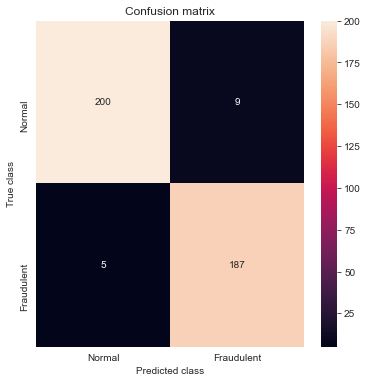

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       209
           1       0.95      0.97      0.96       192

    accuracy                           0.97       401
   macro avg       0.96      0.97      0.97       401
weighted avg       0.97      0.97      0.97       401

Random Forest
Random Forest


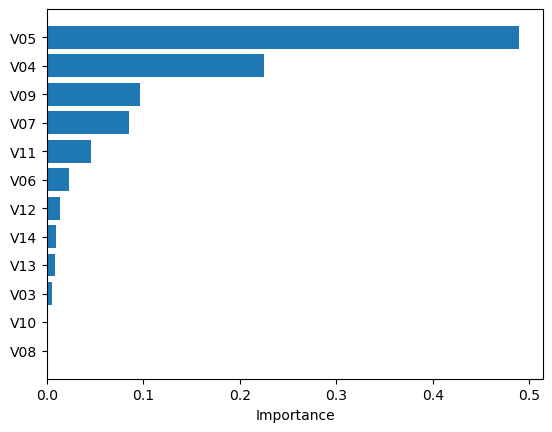

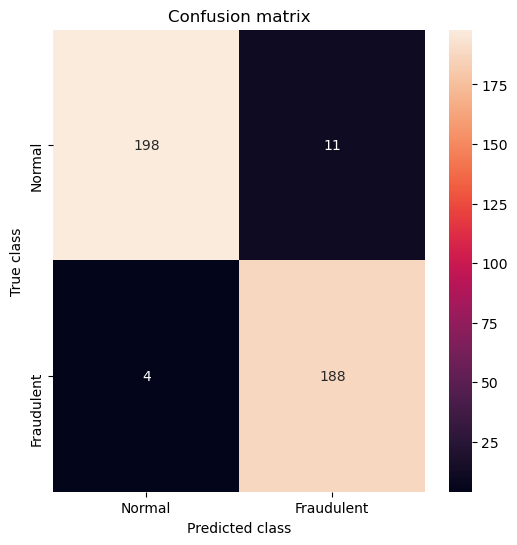

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       209
           1       0.94      0.98      0.96       192

    accuracy                           0.96       401
   macro avg       0.96      0.96      0.96       401
weighted avg       0.96      0.96      0.96       401

LGBM
LGBM


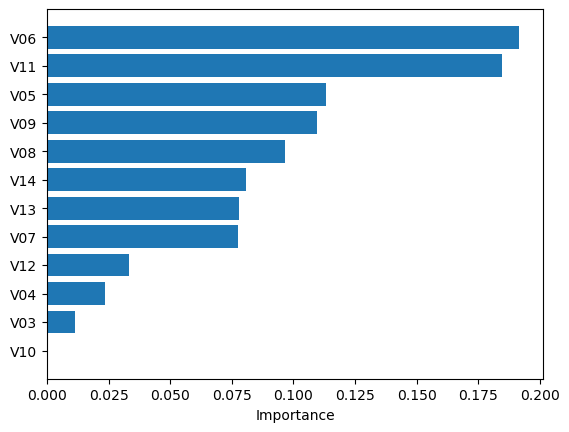

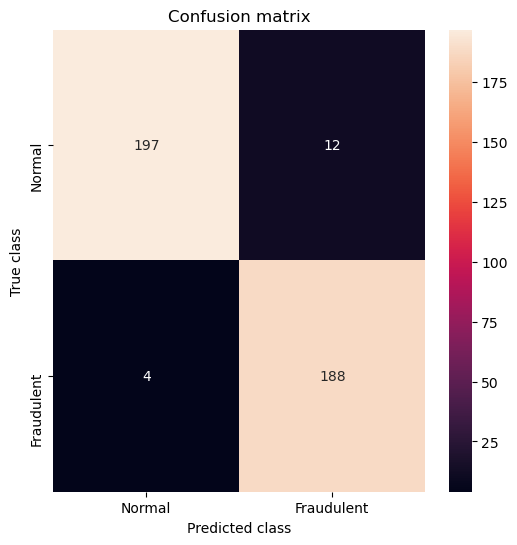

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       209
           1       0.94      0.98      0.96       192

    accuracy                           0.96       401
   macro avg       0.96      0.96      0.96       401
weighted avg       0.96      0.96      0.96       401



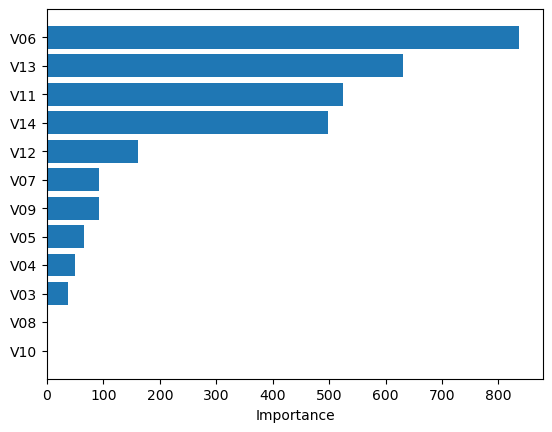

In [6]:
sub_universo =df_completo_normal.sample(n=700, random_state=20)  
nuevo_universo = df_completo_fraud.append(sub_universo)

nuevo_universo = nuevo_universo.sort_values(by=['id']) 


nuevo_universo = nuevo_universo.drop('id', axis=1)


print('genuinas:', round(nuevo_universo['Class'].value_counts()[0]),' (', round(nuevo_universo['Class'].value_counts()[0]/len(nuevo_universo) * 100,2), '% del set de datos)')
print('Fraudulentas:', round(nuevo_universo['Class'].value_counts()[1]),' (', round(nuevo_universo['Class'].value_counts()[1]/len(nuevo_universo) * 100,2), '% del  set de datos)')


X = nuevo_universo.drop('Class', axis=1)
y = nuevo_universo.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '1 - universo 700'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

Universo 2 - 5000

genuinas: 5000  ( 88.73 % del set de datos)
Fraudulentas: 635  ( 11.27 % del  set de datos)
Txs Fraudulentas: 0.11384381338742393
Txs genuinas: 0.8861561866125761
XGBoost
XGBoost


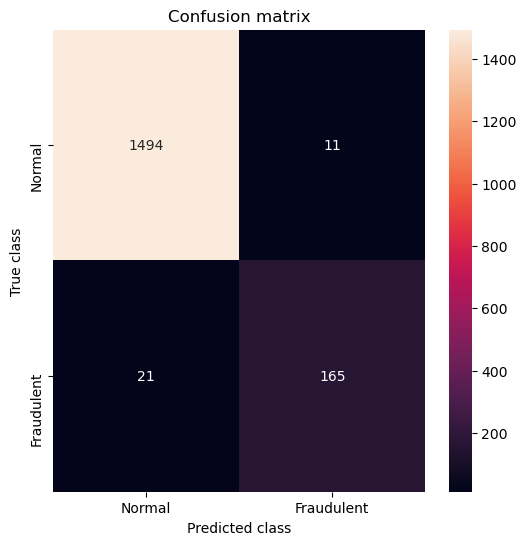

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1505
           1       0.94      0.89      0.91       186

    accuracy                           0.98      1691
   macro avg       0.96      0.94      0.95      1691
weighted avg       0.98      0.98      0.98      1691

Random Forest
Random Forest


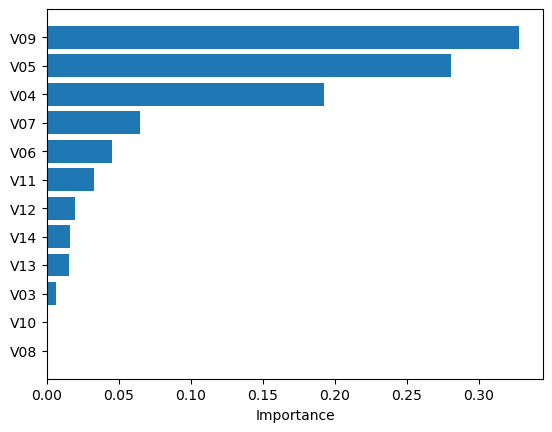

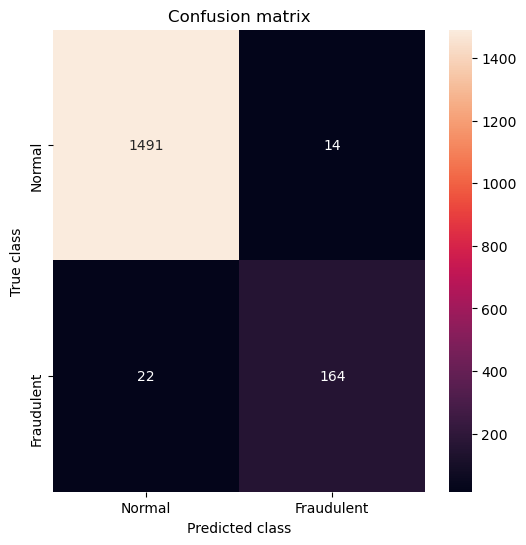

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1505
           1       0.92      0.88      0.90       186

    accuracy                           0.98      1691
   macro avg       0.95      0.94      0.94      1691
weighted avg       0.98      0.98      0.98      1691

LGBM
LGBM


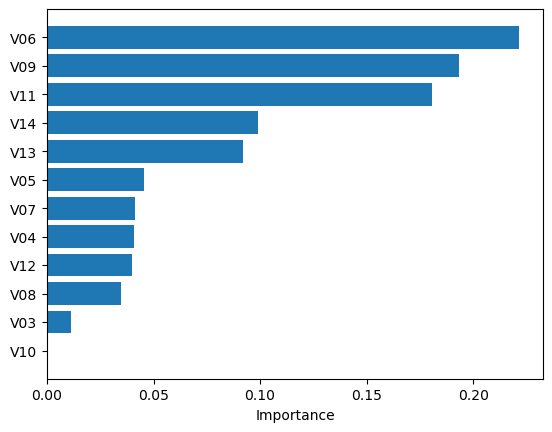

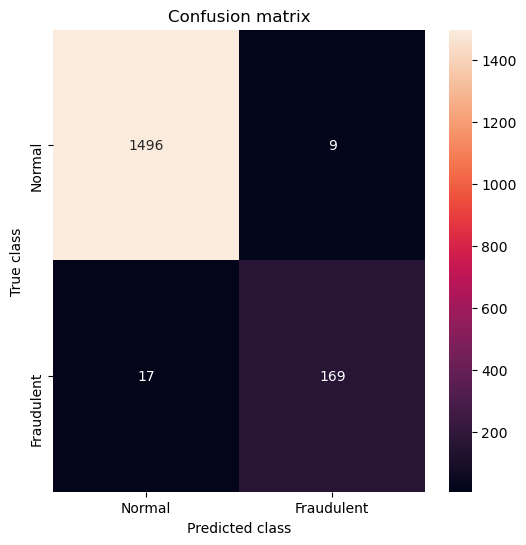

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1505
           1       0.95      0.91      0.93       186

    accuracy                           0.98      1691
   macro avg       0.97      0.95      0.96      1691
weighted avg       0.98      0.98      0.98      1691



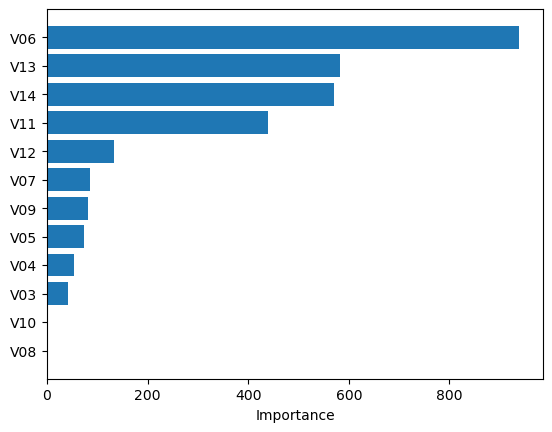

In [7]:
sub_universo =df_completo_normal.sample(n=5000, random_state=20)  
nuevo_universo = df_completo_fraud.append(sub_universo)

nuevo_universo = nuevo_universo.sort_values(by=['id']) 


nuevo_universo = nuevo_universo.drop('id', axis=1)

print('genuinas:', round(nuevo_universo['Class'].value_counts()[0]),' (', round(nuevo_universo['Class'].value_counts()[0]/len(nuevo_universo) * 100,2), '% del set de datos)')
print('Fraudulentas:', round(nuevo_universo['Class'].value_counts()[1]),' (', round(nuevo_universo['Class'].value_counts()[1]/len(nuevo_universo) * 100,2), '% del  set de datos)')


X = nuevo_universo.drop('Class', axis=1)
y = nuevo_universo.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)


Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '2 - universo 5000'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

Universo 3 - 10000

genuinas: 10000  ( 94.03 % del set de datos)
Fraudulentas: 635  ( 5.97 % del  set de datos)
Txs Fraudulentas: 0.057898979043524985
Txs genuinas: 0.942101020956475
XGBoost
XGBoost


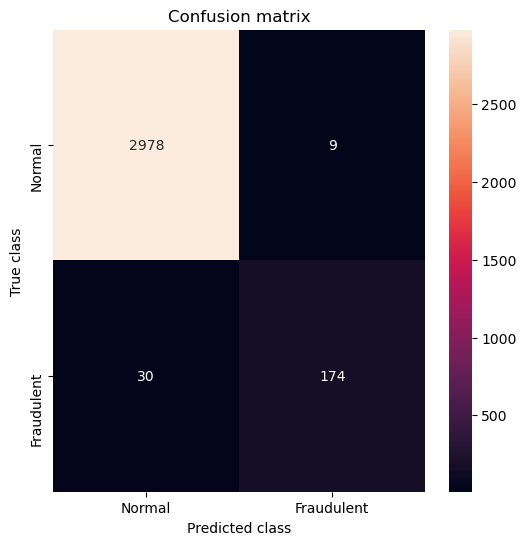

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2987
           1       0.95      0.85      0.90       204

    accuracy                           0.99      3191
   macro avg       0.97      0.92      0.95      3191
weighted avg       0.99      0.99      0.99      3191

Random Forest
Random Forest


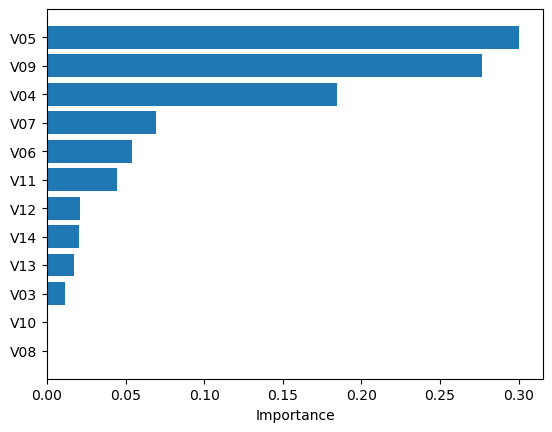

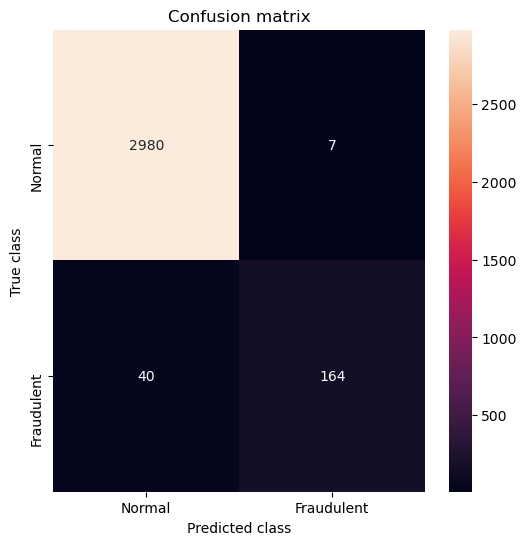

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2987
           1       0.96      0.80      0.87       204

    accuracy                           0.99      3191
   macro avg       0.97      0.90      0.93      3191
weighted avg       0.98      0.99      0.98      3191

LGBM
LGBM


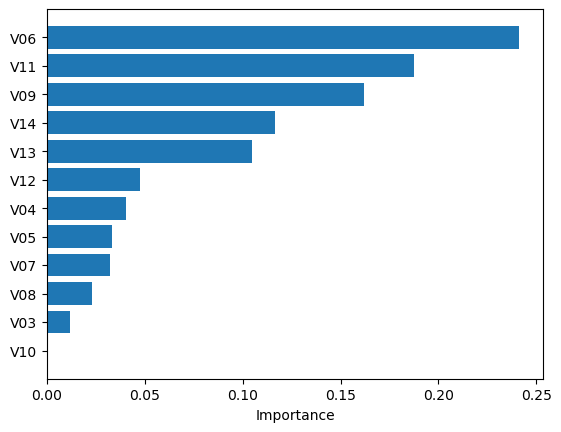

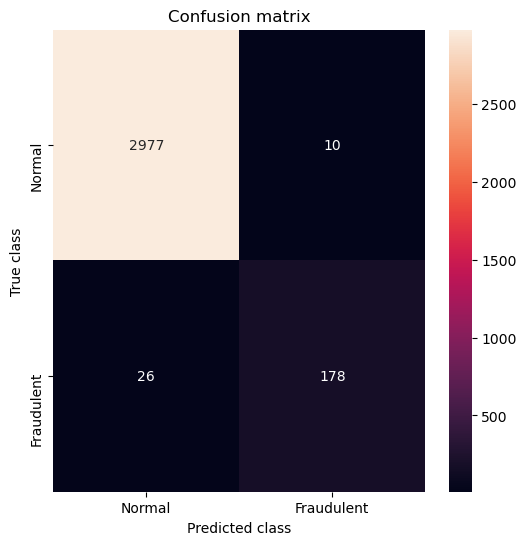

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2987
           1       0.95      0.87      0.91       204

    accuracy                           0.99      3191
   macro avg       0.97      0.93      0.95      3191
weighted avg       0.99      0.99      0.99      3191



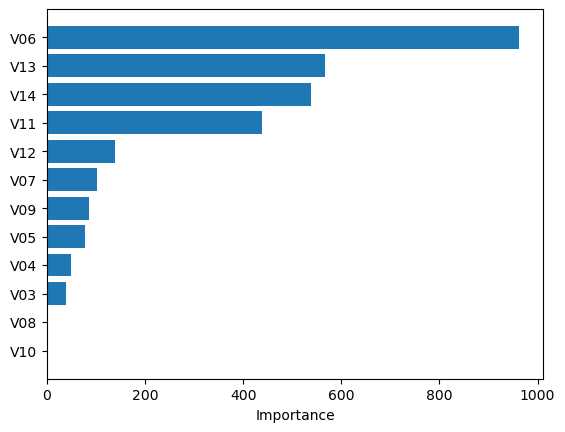

In [8]:
sub_universo =df_completo_normal.sample(n=10000, random_state=20)  
nuevo_universo = df_completo_fraud.append(sub_universo)

nuevo_universo = nuevo_universo.sort_values(by=['id']) 


nuevo_universo = nuevo_universo.drop('id', axis=1)

print('genuinas:', round(nuevo_universo['Class'].value_counts()[0]),' (', round(nuevo_universo['Class'].value_counts()[0]/len(nuevo_universo) * 100,2), '% del set de datos)')
print('Fraudulentas:', round(nuevo_universo['Class'].value_counts()[1]),' (', round(nuevo_universo['Class'].value_counts()[1]/len(nuevo_universo) * 100,2), '% del  set de datos)')


X = nuevo_universo.drop('Class', axis=1)
y = nuevo_universo.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)


Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '3 - universo 10000'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

Universo 4 - 50000

genuinas: 50000  ( 98.75 % del set de datos)
Fraudulentas: 635  ( 1.25 % del  set de datos)
Txs Fraudulentas: 0.012921792122785238
Txs genuinas: 0.9870782078772148
XGBoost
XGBoost


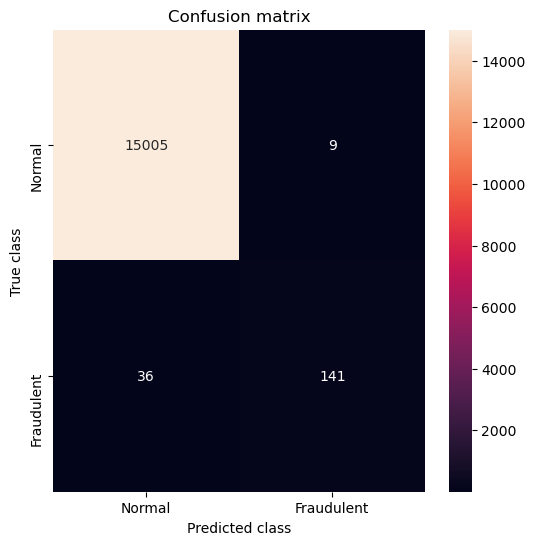

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15014
           1       0.94      0.80      0.86       177

    accuracy                           1.00     15191
   macro avg       0.97      0.90      0.93     15191
weighted avg       1.00      1.00      1.00     15191

Random Forest
Random Forest


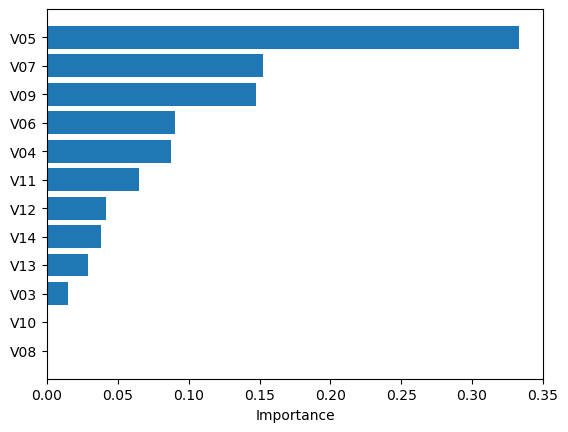

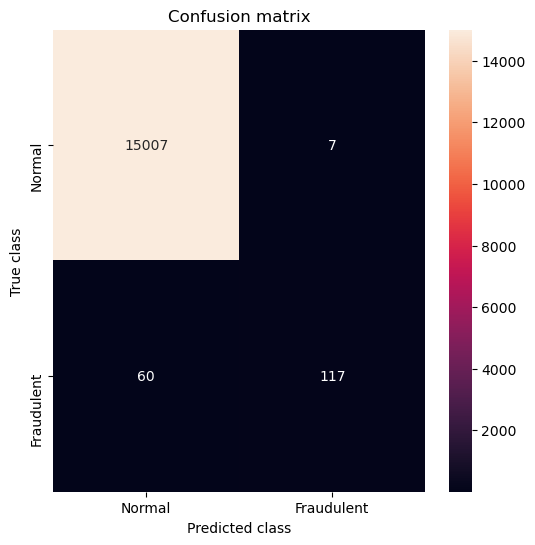

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15014
           1       0.94      0.66      0.78       177

    accuracy                           1.00     15191
   macro avg       0.97      0.83      0.89     15191
weighted avg       1.00      1.00      1.00     15191

LGBM
LGBM


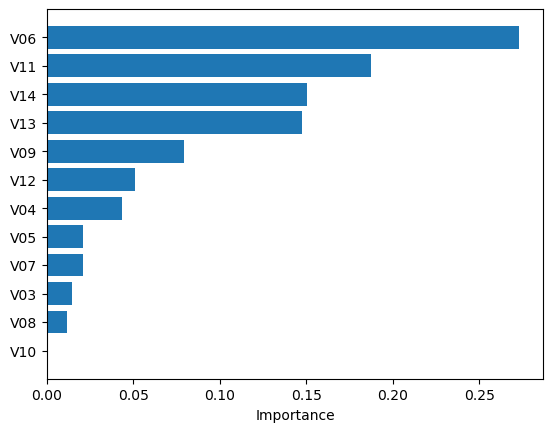

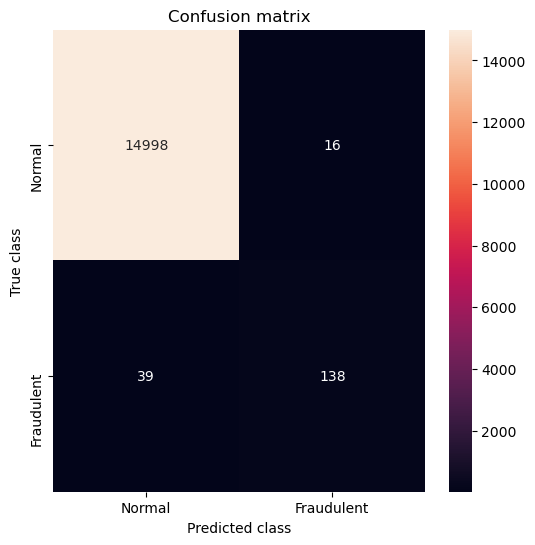

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15014
           1       0.90      0.78      0.83       177

    accuracy                           1.00     15191
   macro avg       0.95      0.89      0.92     15191
weighted avg       1.00      1.00      1.00     15191



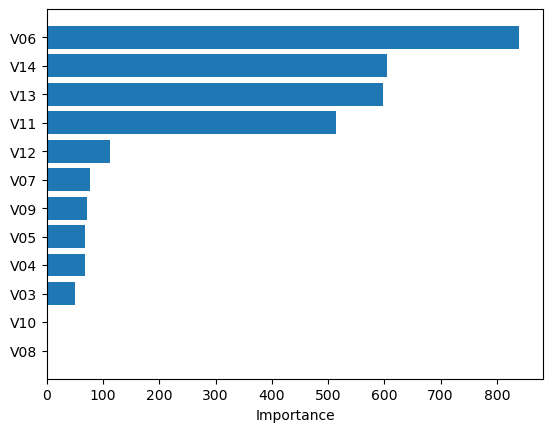

In [9]:
sub_universo =df_completo_normal.sample(n=50000, random_state=20)  
nuevo_universo = df_completo_fraud.append(sub_universo)

nuevo_universo = nuevo_universo.sort_values(by=['id']) 

nuevo_universo = nuevo_universo.drop('id', axis=1)

print('genuinas:', round(nuevo_universo['Class'].value_counts()[0]),' (', round(nuevo_universo['Class'].value_counts()[0]/len(nuevo_universo) * 100,2), '% del set de datos)')
print('Fraudulentas:', round(nuevo_universo['Class'].value_counts()[1]),' (', round(nuevo_universo['Class'].value_counts()[1]/len(nuevo_universo) * 100,2), '% del  set de datos)')


X = nuevo_universo.drop('Class', axis=1)
y = nuevo_universo.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)


Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '4 - universo 50000'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

universo 5 - 100000

genuinas: 100000  ( 99.37 % del set de datos)
Fraudulentas: 635  ( 0.63 % del  set de datos)
Txs Fraudulentas: 0.006217704843563682
Txs genuinas: 0.9937822951564363
XGBoost
XGBoost


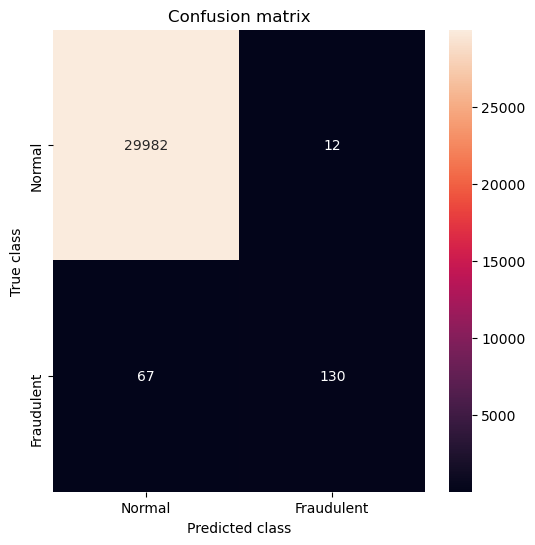

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29994
           1       0.92      0.66      0.77       197

    accuracy                           1.00     30191
   macro avg       0.96      0.83      0.88     30191
weighted avg       1.00      1.00      1.00     30191

Random Forest
Random Forest


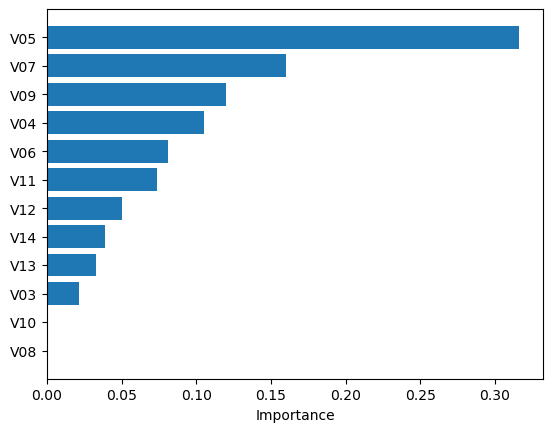

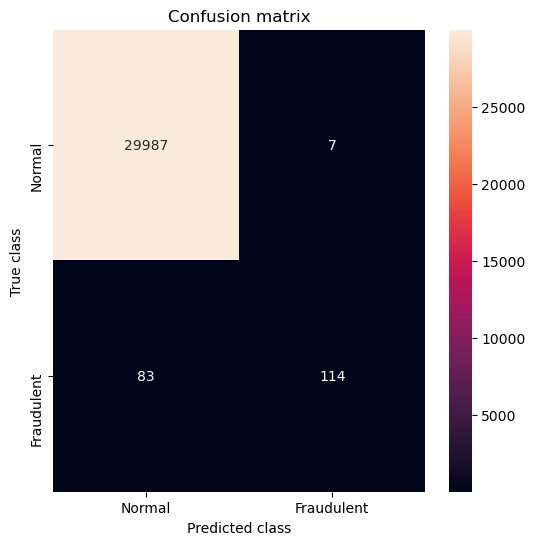

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29994
           1       0.94      0.58      0.72       197

    accuracy                           1.00     30191
   macro avg       0.97      0.79      0.86     30191
weighted avg       1.00      1.00      1.00     30191

LGBM
LGBM


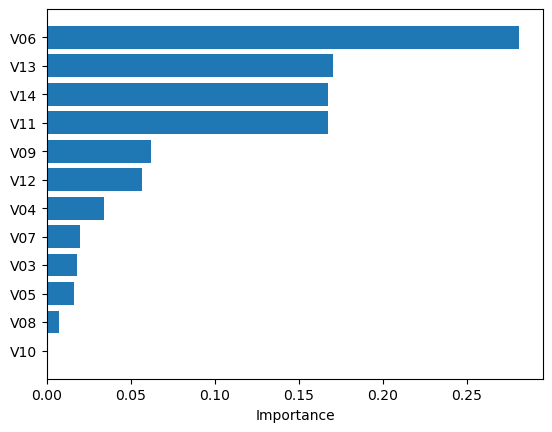

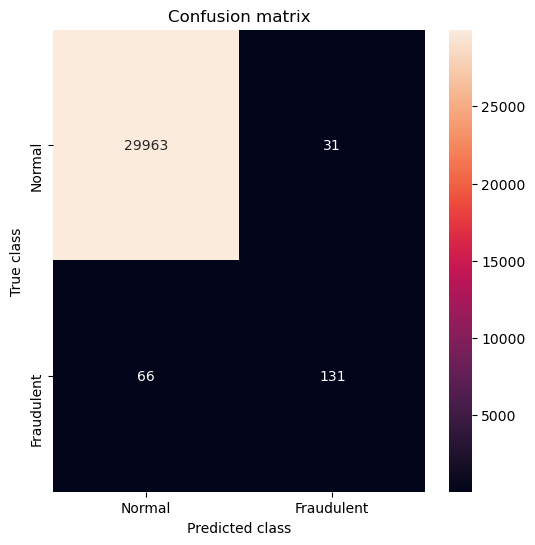

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29994
           1       0.81      0.66      0.73       197

    accuracy                           1.00     30191
   macro avg       0.90      0.83      0.86     30191
weighted avg       1.00      1.00      1.00     30191



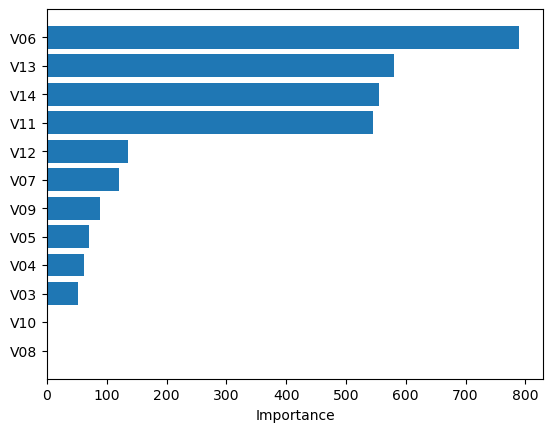

In [10]:
sub_universo =df_completo_normal.sample(n=100000, random_state=20)  
nuevo_universo = df_completo_fraud.append(sub_universo)

nuevo_universo = nuevo_universo.sort_values(by=['id']) 

nuevo_universo = nuevo_universo.drop('id', axis=1)

print('genuinas:', round(nuevo_universo['Class'].value_counts()[0]),' (', round(nuevo_universo['Class'].value_counts()[0]/len(nuevo_universo) * 100,2), '% del set de datos)')
print('Fraudulentas:', round(nuevo_universo['Class'].value_counts()[1]),' (', round(nuevo_universo['Class'].value_counts()[1]/len(nuevo_universo) * 100,2), '% del  set de datos)')


X = nuevo_universo.drop('Class', axis=1)
y = nuevo_universo.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)


Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '5 - universo 100000'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

Universo 6 - 150000

genuinas: 150000  ( 99.58 % del set de datos)
Fraudulentas: 635  ( 0.42 % del  set de datos)
Txs Fraudulentas: 0.00393573840142635
Txs genuinas: 0.9960642615985736
XGBoost
XGBoost


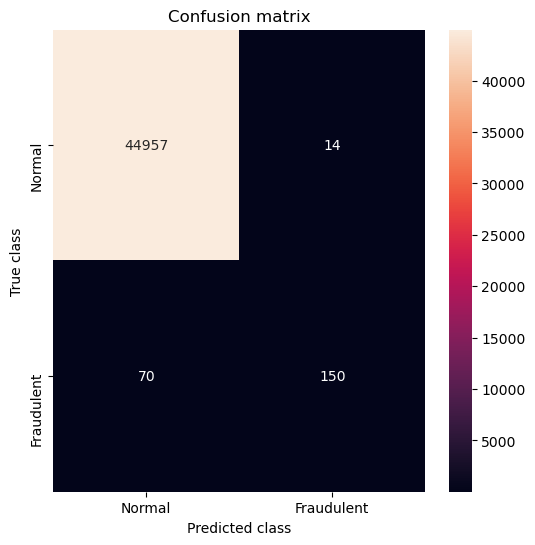

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44971
           1       0.91      0.68      0.78       220

    accuracy                           1.00     45191
   macro avg       0.96      0.84      0.89     45191
weighted avg       1.00      1.00      1.00     45191

Random Forest
Random Forest


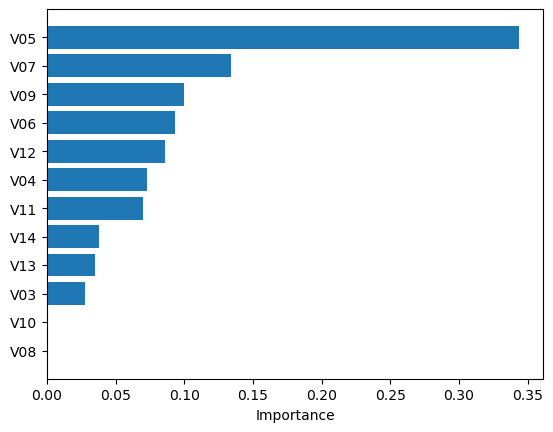

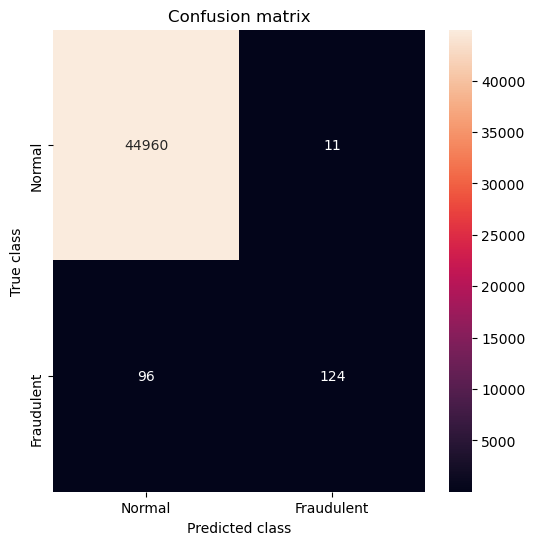

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44971
           1       0.92      0.56      0.70       220

    accuracy                           1.00     45191
   macro avg       0.96      0.78      0.85     45191
weighted avg       1.00      1.00      1.00     45191

LGBM
LGBM


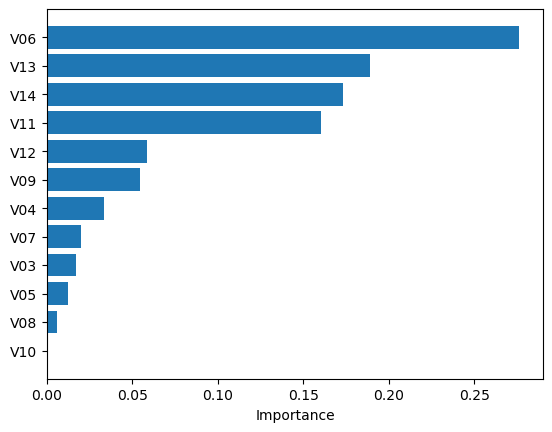

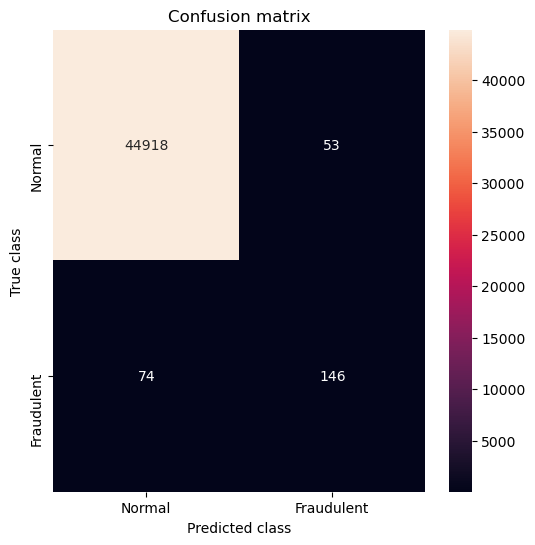

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44971
           1       0.73      0.66      0.70       220

    accuracy                           1.00     45191
   macro avg       0.87      0.83      0.85     45191
weighted avg       1.00      1.00      1.00     45191



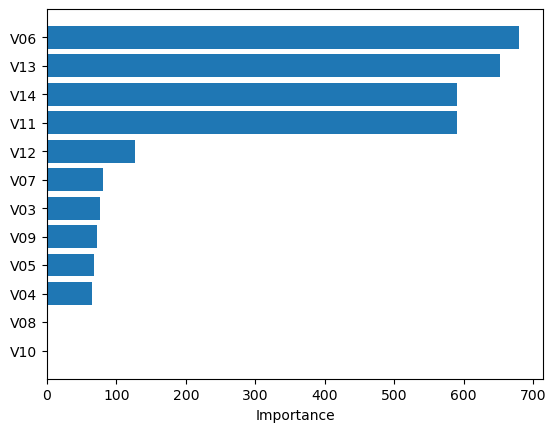

In [11]:
sub_universo =df_completo_normal.sample(n=150000, random_state=20)  
nuevo_universo = df_completo_fraud.append(sub_universo)

nuevo_universo = nuevo_universo.sort_values(by=['id']) 

nuevo_universo = nuevo_universo.drop('id', axis=1)

print('genuinas:', round(nuevo_universo['Class'].value_counts()[0]),' (', round(nuevo_universo['Class'].value_counts()[0]/len(nuevo_universo) * 100,2), '% del set de datos)')
print('Fraudulentas:', round(nuevo_universo['Class'].value_counts()[1]),' (', round(nuevo_universo['Class'].value_counts()[1]/len(nuevo_universo) * 100,2), '% del  set de datos)')


X = nuevo_universo.drop('Class', axis=1)
y = nuevo_universo.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)


Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '6 - universo 150000'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

universo 7 - 250000

genuinas: 250000  ( 99.75 % del set de datos)
Fraudulentas: 635  ( 0.25 % del  set de datos)
Txs Fraudulentas: 0.00242242538929801
Txs genuinas: 0.997577574610702
XGBoost
XGBoost


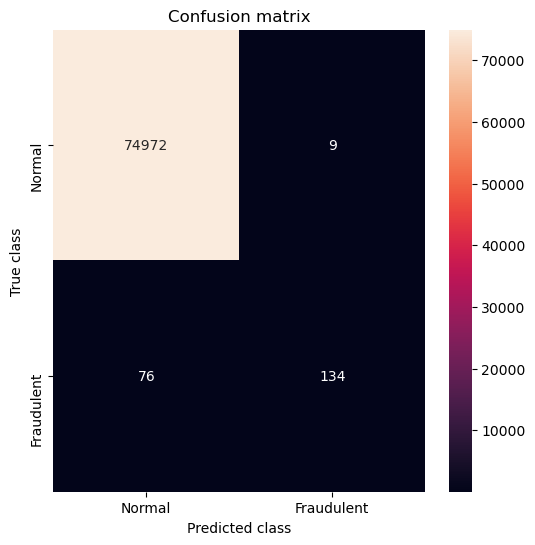

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74981
           1       0.94      0.64      0.76       210

    accuracy                           1.00     75191
   macro avg       0.97      0.82      0.88     75191
weighted avg       1.00      1.00      1.00     75191

Random Forest
Random Forest


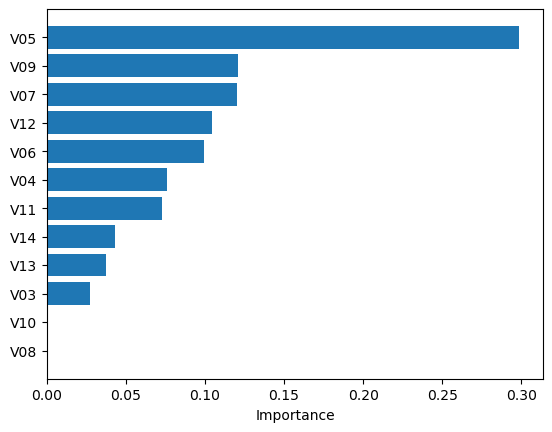

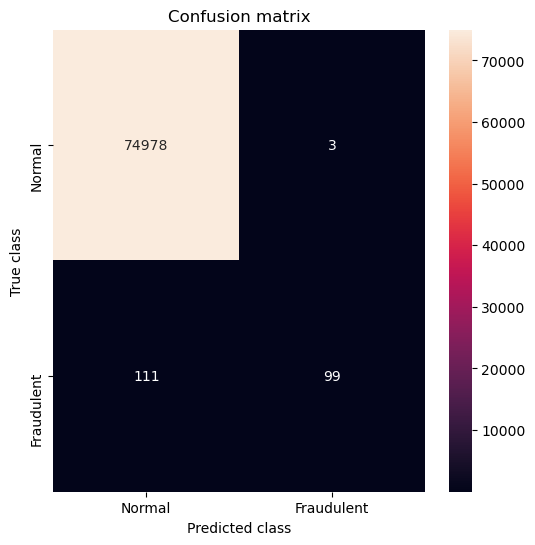

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74981
           1       0.97      0.47      0.63       210

    accuracy                           1.00     75191
   macro avg       0.98      0.74      0.82     75191
weighted avg       1.00      1.00      1.00     75191

LGBM
LGBM


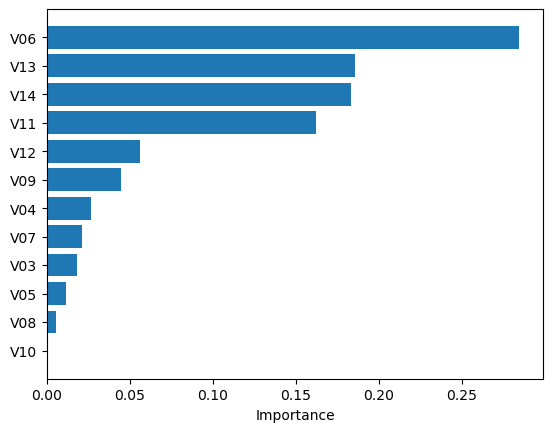

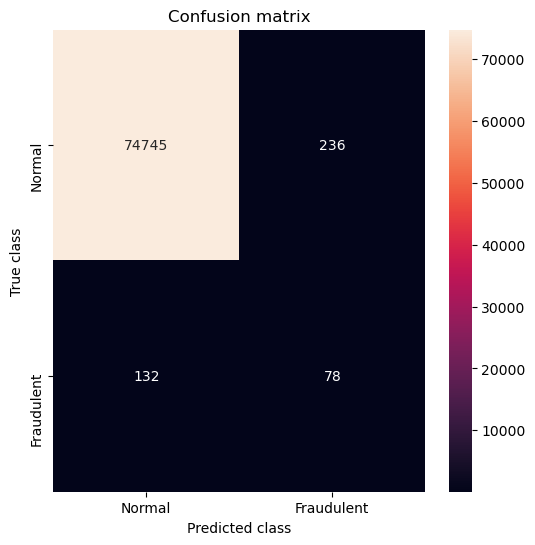

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74981
           1       0.25      0.37      0.30       210

    accuracy                           1.00     75191
   macro avg       0.62      0.68      0.65     75191
weighted avg       1.00      1.00      1.00     75191



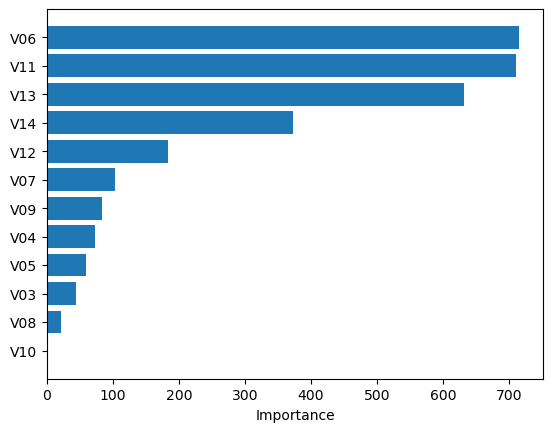

In [12]:
sub_universo =df_completo_normal.sample(n=250000, random_state=20)  
nuevo_universo = df_completo_fraud.append(sub_universo)

nuevo_universo = nuevo_universo.sort_values(by=['id']) 

nuevo_universo = nuevo_universo.drop('id', axis=1)

print('genuinas:', round(nuevo_universo['Class'].value_counts()[0]),' (', round(nuevo_universo['Class'].value_counts()[0]/len(nuevo_universo) * 100,2), '% del set de datos)')
print('Fraudulentas:', round(nuevo_universo['Class'].value_counts()[1]),' (', round(nuevo_universo['Class'].value_counts()[1]/len(nuevo_universo) * 100,2), '% del  set de datos)')


X = nuevo_universo.drop('Class', axis=1)
y = nuevo_universo.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)



Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '7 - universo 250000'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

Univeros 8 - 8completo

genuinas: 566613  ( 99.89 % del set de datos)
Fraudulentas: 635  ( 0.11 % del  set de datos)
Txs Fraudulentas: 0.001153440299390792
Txs genuinas: 0.9988465597006092
XGBoost
XGBoost


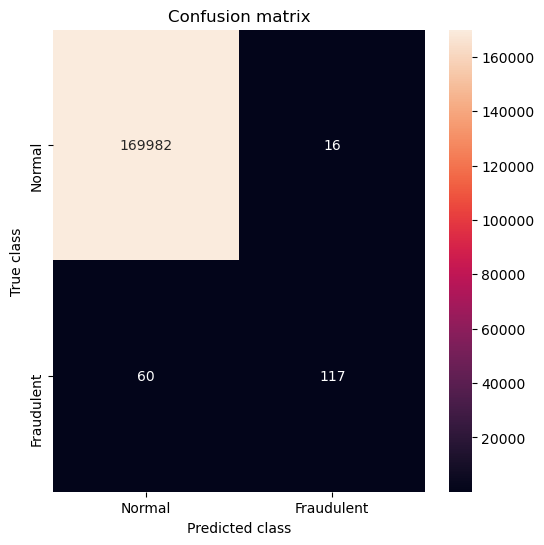

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.88      0.66      0.75       177

    accuracy                           1.00    170175
   macro avg       0.94      0.83      0.88    170175
weighted avg       1.00      1.00      1.00    170175

Random Forest
Random Forest


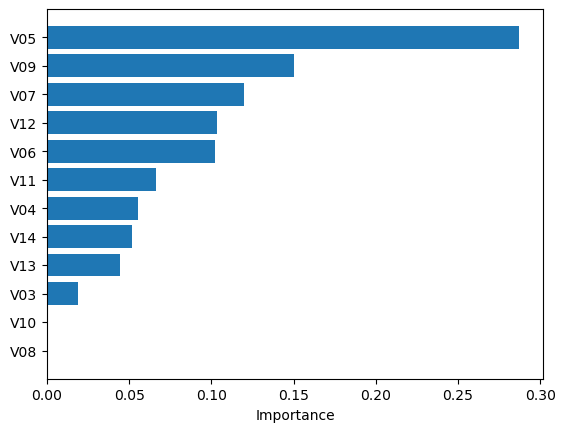

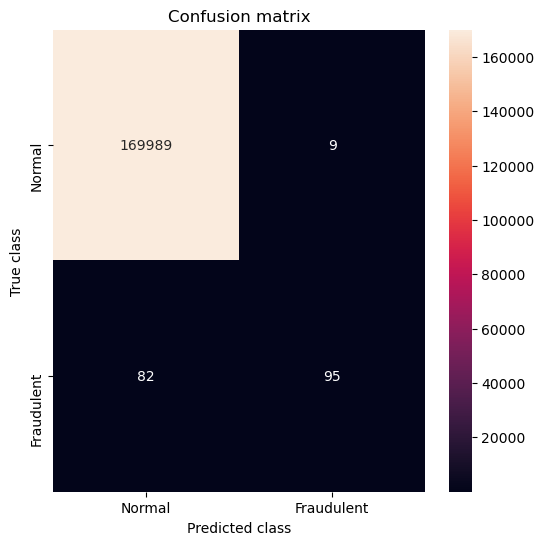

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.91      0.54      0.68       177

    accuracy                           1.00    170175
   macro avg       0.96      0.77      0.84    170175
weighted avg       1.00      1.00      1.00    170175

LGBM
LGBM


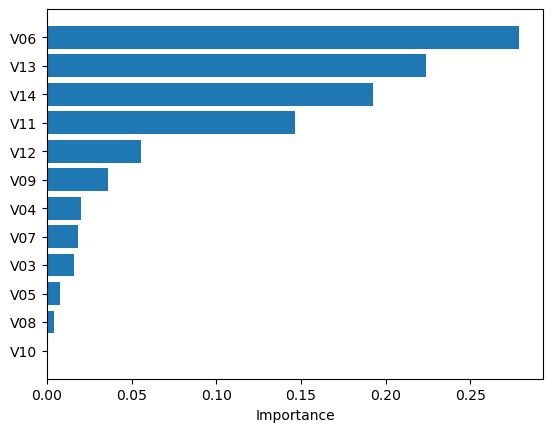

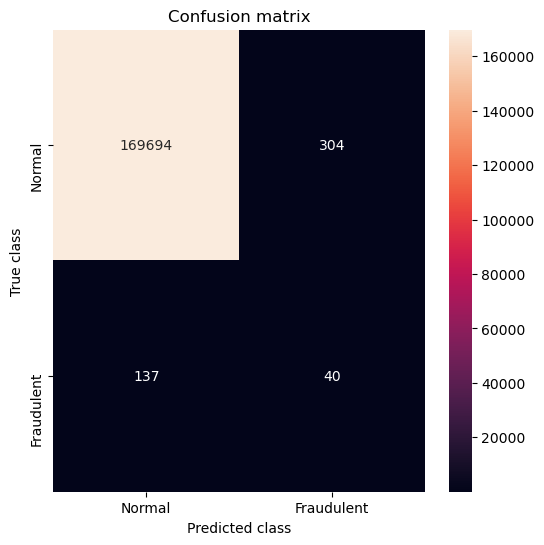

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.12      0.23      0.15       177

    accuracy                           1.00    170175
   macro avg       0.56      0.61      0.58    170175
weighted avg       1.00      1.00      1.00    170175



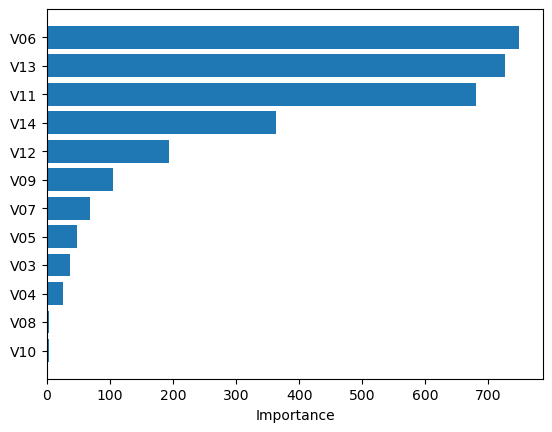

In [13]:


nuevo_universo = df 

nuevo_universo = nuevo_universo.drop('id', axis=1)

print('genuinas:', round(nuevo_universo['Class'].value_counts()[0]),' (', round(nuevo_universo['Class'].value_counts()[0]/len(nuevo_universo) * 100,2), '% del set de datos)')
print('Fraudulentas:', round(nuevo_universo['Class'].value_counts()[1]),' (', round(nuevo_universo['Class'].value_counts()[1]/len(nuevo_universo) * 100,2), '% del  set de datos)')

X = nuevo_universo.drop('Class', axis=1)
y = nuevo_universo.Class


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)



Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '8 - universo completo'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

Comparacion de Modelos

<AxesSubplot:ylabel='tipo_muestreo'>

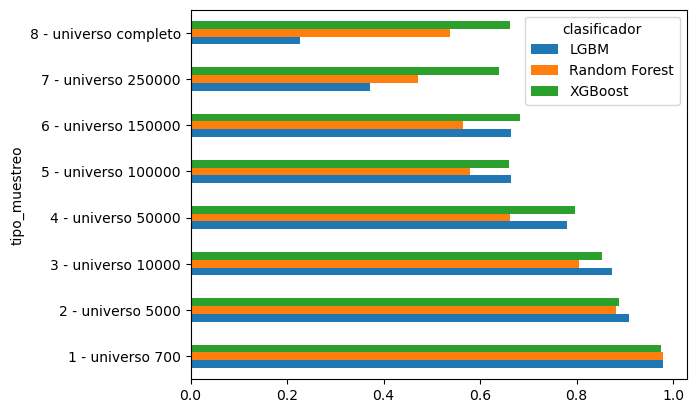

In [14]:
df_pivot = pd.pivot_table(
	scores_df,
	values="recall_tipo_1",
	index="tipo_muestreo",
	columns="clasificador",
	aggfunc=np.mean
)


# Plot a bar chart using the DF
df_pivot.plot(kind="barh")

Curvas RROC por Clasificador y sub universo

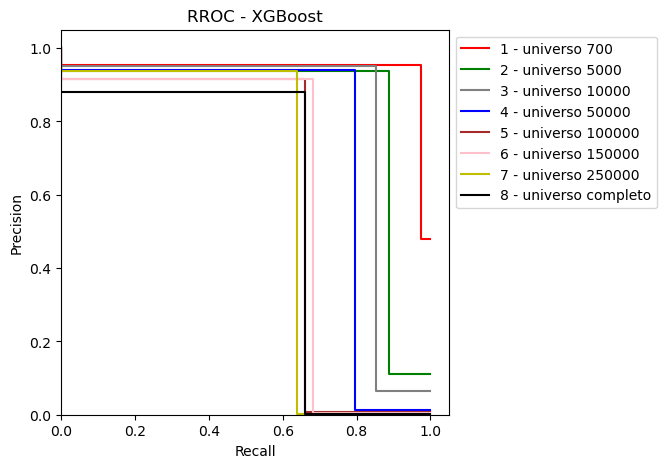

In [15]:
colors = cycle(["r","b", "y", "g", "brown", "k", "grey","pink"])

_, ax = plt.subplots(figsize=(5, 5))

for i, color in zip(range(len(scores_rroc_df)), colors):
    if scores_rroc_df.loc[i,"clasificador"] == 'XGBoost':
    
        precision, recall, _ = scores_rroc_df.loc[i,"resu_rroc"]
        display = PrecisionRecallDisplay(recall=recall, precision=precision)
        display.plot(ax=ax, name=f"{scores_rroc_df.loc[i,'tipo_muestreo']}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()

# set the legend and the axes


ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])

ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.0, 1.0))
ax.set_title("RROC - XGBoost")


plt.show()

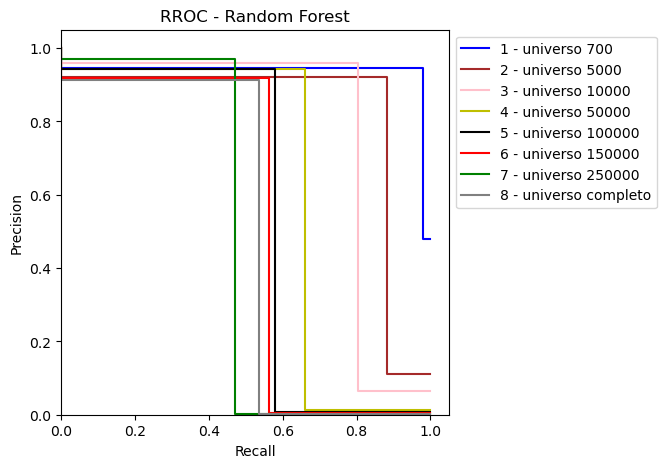

In [16]:
colors = cycle(["r","b", "y", "g", "brown", "k", "grey","pink"])

_, ax = plt.subplots(figsize=(5, 5))

for i, color in zip(range(len(scores_rroc_df)), colors):
    if scores_rroc_df.loc[i,"clasificador"] == 'Random Forest':
    
        precision, recall, _ = scores_rroc_df.loc[i,"resu_rroc"]
        display = PrecisionRecallDisplay(recall=recall, precision=precision)
        display.plot(ax=ax, name=f"{scores_rroc_df.loc[i,'tipo_muestreo']}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()

# set the legend and the axes
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])

ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.0, 1.0))
ax.set_title("RROC - Random Forest")

plt.show()

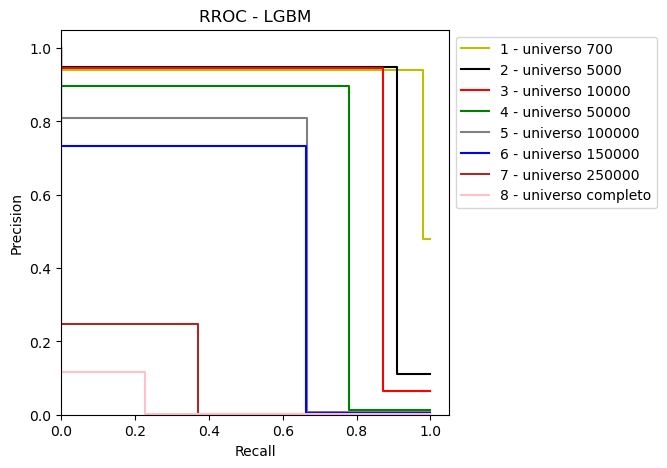

In [17]:
colors = cycle(["r","b", "y", "g", "brown", "k", "grey","pink"])

_, ax = plt.subplots(figsize=(5, 5))

for i, color in zip(range(len(scores_rroc_df)), colors):
    if scores_rroc_df.loc[i,"clasificador"] == 'LGBM':
    
        precision, recall, _ = scores_rroc_df.loc[i,"resu_rroc"]
        display = PrecisionRecallDisplay(recall=recall, precision=precision)
        display.plot(ax=ax, name=f"{scores_rroc_df.loc[i,'tipo_muestreo']}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()


# set the legend and the axes
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])

ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.0, 1.0))
ax.set_title("RROC - LGBM")

plt.show()